# Multi-Class classification using CNN
Main point of the notebook:
Dealing with overfitting using two techniques of data augmentation and dropout

We follow a basic machine learning workflow in this notebook
1. Load the data, Examine and Understand the data
2. Build an input pipeline
3. Build the Model
4. Train the model
5. Test the model
6. Improve the model and repeat the process 

## 1. Import required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 2. Download dataset

In [83]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin = dataset_url, extract = True)
data_dir = pathlib.Path(data_dir).with_suffix('')
# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

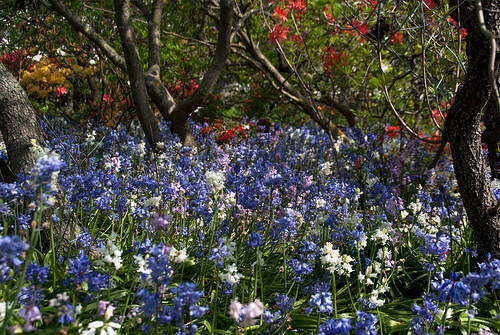

In [50]:
# List of roses 
roses = list(data_dir.glob('roses/*.jpg'))
# List of tulips
tulips = list(data_dir.glob('tulips/*.jpg'))
PIL.Image.open(tulips[1])

## 3. Build input pipeline

In [127]:
## Load data using Keras utility (load data off disk from a directory of image to a tf.data.Dataset)

#Required inputs for creating a dataset for training
batch_size = 32
img_height = 180
img_width = 180

In [86]:
# Training dataset 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [87]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [88]:
# Flower class names 
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


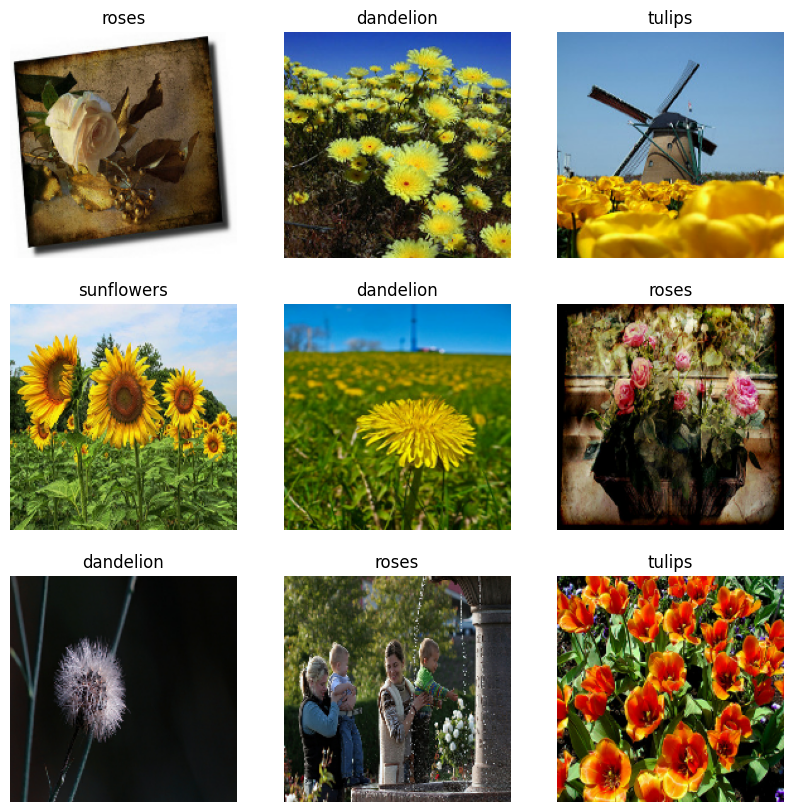

In [89]:
# Visualise the data to check the images and labels

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [98]:
# These are the dataset for training
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

tf.Tensor(
[[[[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.52338898e+02 2.51338898e+02 2.30913895e+02]
   [2.52533340e+02 2.51533340e+02 2.32683350e+02]
   [2.52725006e+02 2.51725006e+02 2.32875000e+02]]

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.53152771e+02 2.52122223e+02 2.30449997e+02]
   [2.54241653e+02 2.52483307e+02 2.30449997e+02]
   [2.54449997e+02 2.53094467e+02 2.30094467e+02]]

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2.55000000e+02 2.55000000e+02 2.55000000e+02]
   ...
   [2.53000000e+02 2.51000000e+02 2.28888916e+02]
   [2.52749969e+02 2.50583298e+02 2.27416626e+02]
   [2.53527802e+02 2.51527802e+02 2.28527802e+02]]

  ...

  [[8.31666641e+01 7.49583359e+01 2.73333321e+01]
   [3

In [103]:
# Configure the dataset for training 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
# Standardise the data (the  images are in the [0, 255] range that are not ideal for the neural network)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
# Check the minimum and maximum values of the images
print(np.min(image_batch),np.max(image_batch))


0.0 1.0


## 4.Build model

In [99]:
# Building CNN model
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))
  

C:\Users\shsha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
#Model Summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the model

In [105]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/20


92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.3382 - loss: 1.5029 - val_accuracy: 0.5967 - val_loss: 1.0015
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.6064 - loss: 0.9940 - val_accuracy: 0.5995 - val_loss: 1.0268
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.6782 - loss: 0.8417 - val_accuracy: 0.6580 - val_loss: 0.8976
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7634 - loss: 0.6415 - val_accuracy: 0.6526 - val_loss: 0.8935
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.8592 - loss: 0.3936 - val_accuracy: 0.6785 - val_loss: 0.8874
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9088 - loss: 0.2676 - val_accuracy: 0.6812 - val_loss: 1.0230
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.9608 - loss: 0.1412 - val_accuracy: 0.6594 - val_loss: 1.3951
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.9744 - loss: 0.0820 - val_accuracy: 0.645

## 6. Evaluate the model

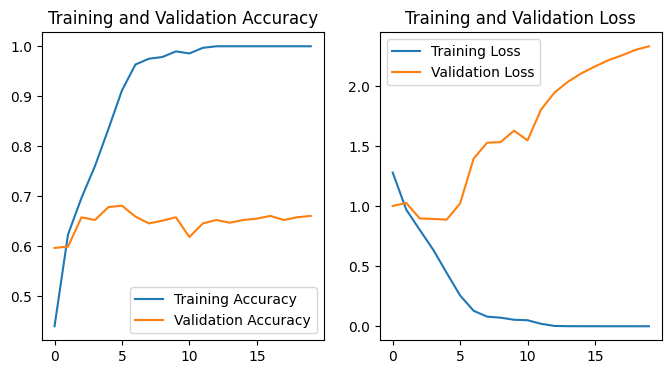

In [109]:
# Visualising training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Loss')

plt.show()


In the plots above, it can be seen that the training accuracy is linearly increasing over time, whereas validation accuracy stalls around 60 % in the training process. This is a sign of overfitting where the difference between training and validation accuracy is noticeable. Overfitting can happen due to several reasons. One of them which is the case in this example is the small number of training dataset. It caused the model learn from noises or unwanted details of the training dataset. In this case, the model has a difficult time generalizing on a new dataset. 
There are multiple solutions to deal with overfitting in the training process. One of them is data augmentation and add dropout to the model which we adopted in this project. 

## 7. Improve the model 

In [118]:
# Data Augmentation

model = Sequential()

model.add(layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
data_augmentation = model

C:\Users\shsha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


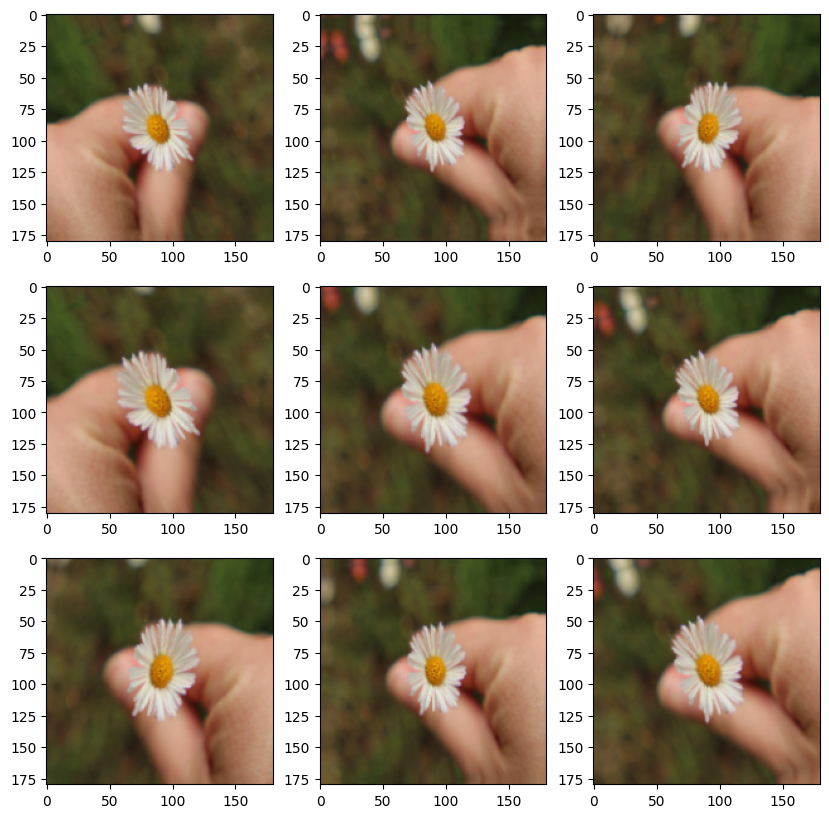

In [120]:
# Visualise a few augmented examples of data 

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
        


### 7.1. Build the new model

In [121]:
# Another technique to reduce overfitting is to introduce dropout regularization to the network.

# Building the new CNN model with augmented data and introducing dropout
model_new = data_augmentation

model_new.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_new.add(layers.Conv2D(16, 3, padding = 'same', activation = 'relu'))
model_new.add(layers.MaxPooling2D())
model_new.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model_new.add(layers.MaxPooling2D())
model_new.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model_new.add(layers.MaxPooling2D())
model_new.add(layers.Dropout(0.2))
model_new.add(layers.Flatten())
model_new.add(layers.Dense(128, activation='relu'))
model_new.add(layers.Dense(num_classes))
  



C:\Users\shsha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
# Compile the new model

model.compile(optimizer= 'adam', 
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [123]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 7.2 Train the new model

In [125]:
epochs = 20
history = model_new.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.4428 - loss: 1.2948 - val_accuracy: 0.5886 - val_loss: 1.0234
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.5914 - loss: 1.0330 - val_accuracy: 0.6213 - val_loss: 1.0119
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.6267 - loss: 0.9568 - val_accuracy: 0.6376 - val_loss: 0.9318
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.6574 - loss: 0.8933 - val_accuracy: 0.6826 - val_loss: 0.8592
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.6905 - loss: 0.8231 - val_accuracy: 0.7016 - val_loss: 0.7970
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step - accuracy: 0.7064 - loss: 0.7776 - val_accuracy: 0.6989 - val_loss: 0.8139
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 285ms/step - accuracy: 0.7055 - loss: 0.7720 - val_accuracy: 0.6798 - val_loss: 0.8412
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.7071 - loss: 0.7387 - val_accu

### 7.3 Evaluate the new model 

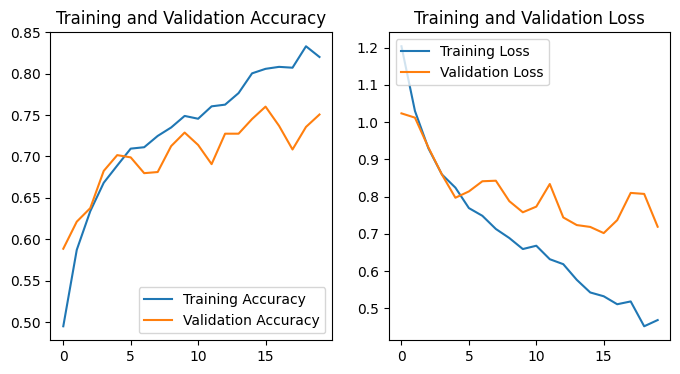

In [126]:
# Visualising training results for the new model (model_new)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Loss')

plt.show()


### 8. Convert the new model to TensorFlow Lite model

In [ ]:
# Convert the model to a TensorFlow Lite model with on-device application

#Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model_new)
tflit_model = converter.convert()


#Save the model
with open('tflit_model', 'wb') as f:
    f.write(tflit_model)

    